# Imports

In [1]:
import sys
sys.path.append("../../src/")
from ECALDataAnalyzer import ECALDataAnalyzer
from TrainData import TrainData
from model_functions import make_gravnet_model
from condensation_loss import CustomLoss, AttLossMetric, RepLossMetric, CowLossMetric, NseLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from callbacks import PlotCallback
from helper_functions import create_output_directory, create_gif_from_pngs
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from Layers import GravNet, global_layers_list

# Load and Plot Data

In [2]:
directory = '../../projects/dis.true.08.21.2024.16.02/training/'
all_files = [directory+"/"+file for file in os.listdir(directory) if not "intersections" in file]

# Load in Training Data

In [3]:
param_intersections = False

In [4]:
data = TrainData(csv_files = all_files[0:10],
                 train_size = 0.8,
                 return_tensor = True,
                 K=100,
                 do_intersections=param_intersections,
                 remove_background=True,
                 min_particles=1)

100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


Total files processed: 10


100%|████████████████████████████████████| 3973/3973 [00:02<00:00, 1353.11it/s]


In [5]:
maxN=-1
train_X, train_y, train_misc = data.get_train_data(maxN)
test_X, test_y, test_misc = data.get_test_data(maxN)

In [11]:
# import h5py
# # Specify file names
# train_filename = 'train_data_strips.h5'
# test_filename = 'test_data_strips.h5'
# # Save testing data
# with h5py.File(test_filename, 'w') as hf:
#     hf.create_dataset('test_X', data=test_X)
#     hf.create_dataset('test_y', data=test_y)
#     hf.create_dataset('test_misc', data=test_misc)
# print(f"Testing data saved to {test_filename}")
# # Save training data
# with h5py.File(train_filename, 'w') as hf:
#     hf.create_dataset('train_X', data=train_X)
#     hf.create_dataset('train_y', data=train_y)
#     hf.create_dataset('train_misc', data=train_misc)
# print(f"Training data saved to {train_filename}")


Testing data saved to test_data_strips.h5
Training data saved to train_data_strips.h5


In [3]:
# import h5py

# # Specify file names
# train_filename = 'train_data_strips.h5'
# test_filename = 'test_data_strips.h5'

# # Load testing data
# with h5py.File(test_filename, 'r') as hf:
#     test_X = hf['test_X'][:]
#     test_y = hf['test_y'][:]
#     test_misc = hf['test_misc'][:]

# print(f"Testing data loaded from {test_filename}")

# # Load training data
# with h5py.File(train_filename, 'r') as hf:
#     train_X = hf['train_X'][:]
#     train_y = hf['train_y'][:]
#     train_misc = hf['train_misc'][:]

# print(f"Training data loaded from {train_filename}")

Testing data loaded from test_data_strips.h5
Training data loaded from train_data_strips.h5


# Initialize Model

In [6]:
batch_size = 64        # Batch size
learning_rate = 0.005  # Initial learning rate
N_epochs = 25         # Number of epochs to train
q_min    = 0.7         # q_min
tB       = 0.1          # minimum beta for clustering
tD       = 0.4          # minimum distance for clustering
ev       = 1000            # Event number to plot

# Assuming `make_gravnet_model` and `custom_loss` are already defined
model = make_gravnet_model(K=train_X.shape[1],
                           N_feat=train_X.shape[2],
                           N_grav_layers=6,
                           N_neighbors=[10,10,10,10,10,10],
                           N_filters=256)
model = make_gravnet_model(K=train_X.shape[1],
                           N_feat=train_X.shape[2],
                           N_grav_layers=3,
                           N_neighbors=20,
                           N_filters=256)

# Produce new output directory for saving plots
outdir = create_output_directory("./out")

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile model
model.compile(optimizer=optimizer, 
              loss=CustomLoss(q_min=q_min),
              metrics=[
                  AttLossMetric(q_min=q_min), 
                  RepLossMetric(q_min=q_min), 
                  CowLossMetric(q_min=q_min), 
                  NseLossMetric(q_min=q_min)
              ])

# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          factor=0.9, 
                                                          patience=5, 
                                                          min_lr=1e-8, 
                                                          verbose=1)
# ECAL Plotting Callback
plot_callback =   PlotCallback(X=train_X[ev:ev+1], 
                               y=train_y[ev:ev+1], 
                               misc=train_misc[ev:ev+1], 
                               model=model, 
                               param_intersections=param_intersections, 
                               tB=tB, 
                               tD=tD,
                               outdir=outdir
                                 ) 

/opt/conda/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


# Training

In [7]:
# Train the model
history = model.fit(x=train_X,
                    y=train_y,
                    batch_size=batch_size,
                    epochs=N_epochs,
                    shuffle=True,
                    validation_data=(test_X, test_y),
                    callbacks=[plot_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/25
1/1 [==============================] - 1s 611ms/step loss: 0.9604 - att_loss_metric: 0.0856 - rep_loss_metric: 0.2025 - cow_loss_metric: 0.2633 - nse_loss_metric: 0.01
End of epoch 1
249/249 [==============================] - 25s 56ms/step - loss: 0.9604 - att_loss_metric: 0.0856 - rep_loss_metric: 0.2025 - cow_loss_metric: 0.2633 - nse_loss_metric: 0.0189 - val_loss: 0.5798 - val_att_loss_metric: 0.1281 - val_rep_loss_metric: 0.1170 - val_cow_loss_metric: 0.3465 - val_nse_loss_metric: 1.0000e-05 - lr: 0.0050
Epoch 2/25
1/1 [==============================] - 0s 28ms/step- loss: 0.5585 - att_loss_metric: 0.1307 - rep_loss_metric: 0.1604 - cow_loss_metric: 0.2921 - nse_loss_metric: 1.0000e-
End of epoch 2
249/249 [==============================] - 11s 45ms/step - loss: 0.5585 - att_loss_metric: 0.0000e+00 - rep_loss_metric: 0.0000e+00 - cow_loss_metric: 0.0000e+00 - nse_loss_metric: 0.0000e+00 - val_loss: 0.5467 - val_att_loss_metric: 0.0000e+00 - val_rep_loss_metric: 0.0000e+

KeyboardInterrupt: 

In [8]:
# Save the model to the pre-made directory "outdir"
model_save_path = f"{outdir}/trained_model"
# Check if the file exists and remove it
if os.path.exists(model_save_path):
    os.remove(model_save_path)
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

INFO:tensorflow:Assets written to: ./out/08_26_2024_0004/trained_model/assets


INFO:tensorflow:Assets written to: ./out/08_26_2024_0004/trained_model/assets


Model saved to ./out/08_26_2024_0004/trained_model


In [14]:
create_gif_from_pngs(outdir,"training.fast",duration=60)
create_gif_from_pngs(outdir,"training.slow",duration=500)

GIF saved at: ./out/08_25_2024_0001/training.fast_ev0.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev1.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev2.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev3.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev4.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev5.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev6.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev7.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev8.png.gif
GIF saved at: ./out/08_25_2024_0001/training.fast_ev9.png.gif
GIF saved at: ./out/08_25_2024_0001/training.slow_ev0.png.gif
GIF saved at: ./out/08_25_2024_0001/training.slow_ev1.png.gif
GIF saved at: ./out/08_25_2024_0001/training.slow_ev2.png.gif
GIF saved at: ./out/08_25_2024_0001/training.slow_ev3.png.gif
GIF saved at: ./out/08_25_2024_0001/training.slow_ev4.png.gif
GIF saved at: ./out/08_25_2024_0001/training.slow_ev5.png.gif
GIF save

# Plotting Metrics

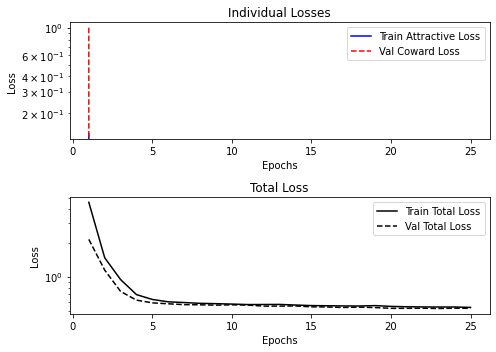

In [30]:
import matplotlib.pyplot as plt

# Extract the metric values
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_attractive_loss = history.history['att_loss_metric']
val_attractive_loss = history.history['val_att_loss_metric']
train_repulsive_loss = history.history['rep_loss_metric']
val_repulsive_loss = history.history['val_rep_loss_metric']
train_coward_loss = history.history['cow_loss_metric']
val_coward_loss = history.history['val_cow_loss_metric']

plt.figure(figsize=(7, 5))

# Plot all the individual losses on the same plot
plt.subplot(2, 1, 1)
plt.plot(epochs, train_attractive_loss, 'b-', label='Train Attractive Loss')
plt.plot(epochs, val_attractive_loss, 'b--', label='Val Attractive Loss')
plt.plot(epochs, train_repulsive_loss, 'g-', label='Train Repulsive Loss')
plt.plot(epochs, val_repulsive_loss, 'g--', label='Val Repulsive Loss')
plt.plot(epochs, train_coward_loss, 'r-', label='Train Coward Loss')
plt.plot(epochs, val_coward_loss, 'r--', label='Val Coward Loss')
plt.title('Individual Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
# Plot the total loss on a separate subplot
plt.subplot(2, 1, 2)
plt.plot(epochs, train_loss, 'k-', label='Train Total Loss')
plt.plot(epochs, val_loss, 'k--', label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.yscale('log')
plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
model = load_model(
    f"{outdir}/trained_model",
    custom_objects={
        'CustomLoss': CustomLoss, 
        'AttLossMetric': AttLossMetric,
        'RepLossMetric': RepLossMetric,
        'CowLossMetric': CowLossMetric,
        'NseLossMetric': NseLossMetric
    }
)

# Evaluating

In [8]:
evaluator = Evaluator(test_X[:100], test_y[:100], test_misc[:100], is_intersections=param_intersections)
#evaluator = Evaluator(train_X[:100], train_y[:100], train_misc[:100], is_intersections=param_intersections)
evaluator.load_model(model)
evaluator.predict()
evaluator.cluster(0.1,0.3)

4/4 [==============================] - 0s 12ms/step


# Plotting

Randomly generated event number = 83


array([<Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='ECAL::peaks (X)', ylabel='ECAL::peaks (Y)'>,
       <Axes: xlabel='Latent X Coordinate', ylabel='Latent Y Coordinate'>,
       <Axes: xlabel='Learned $\\beta$'>], dtype=object)

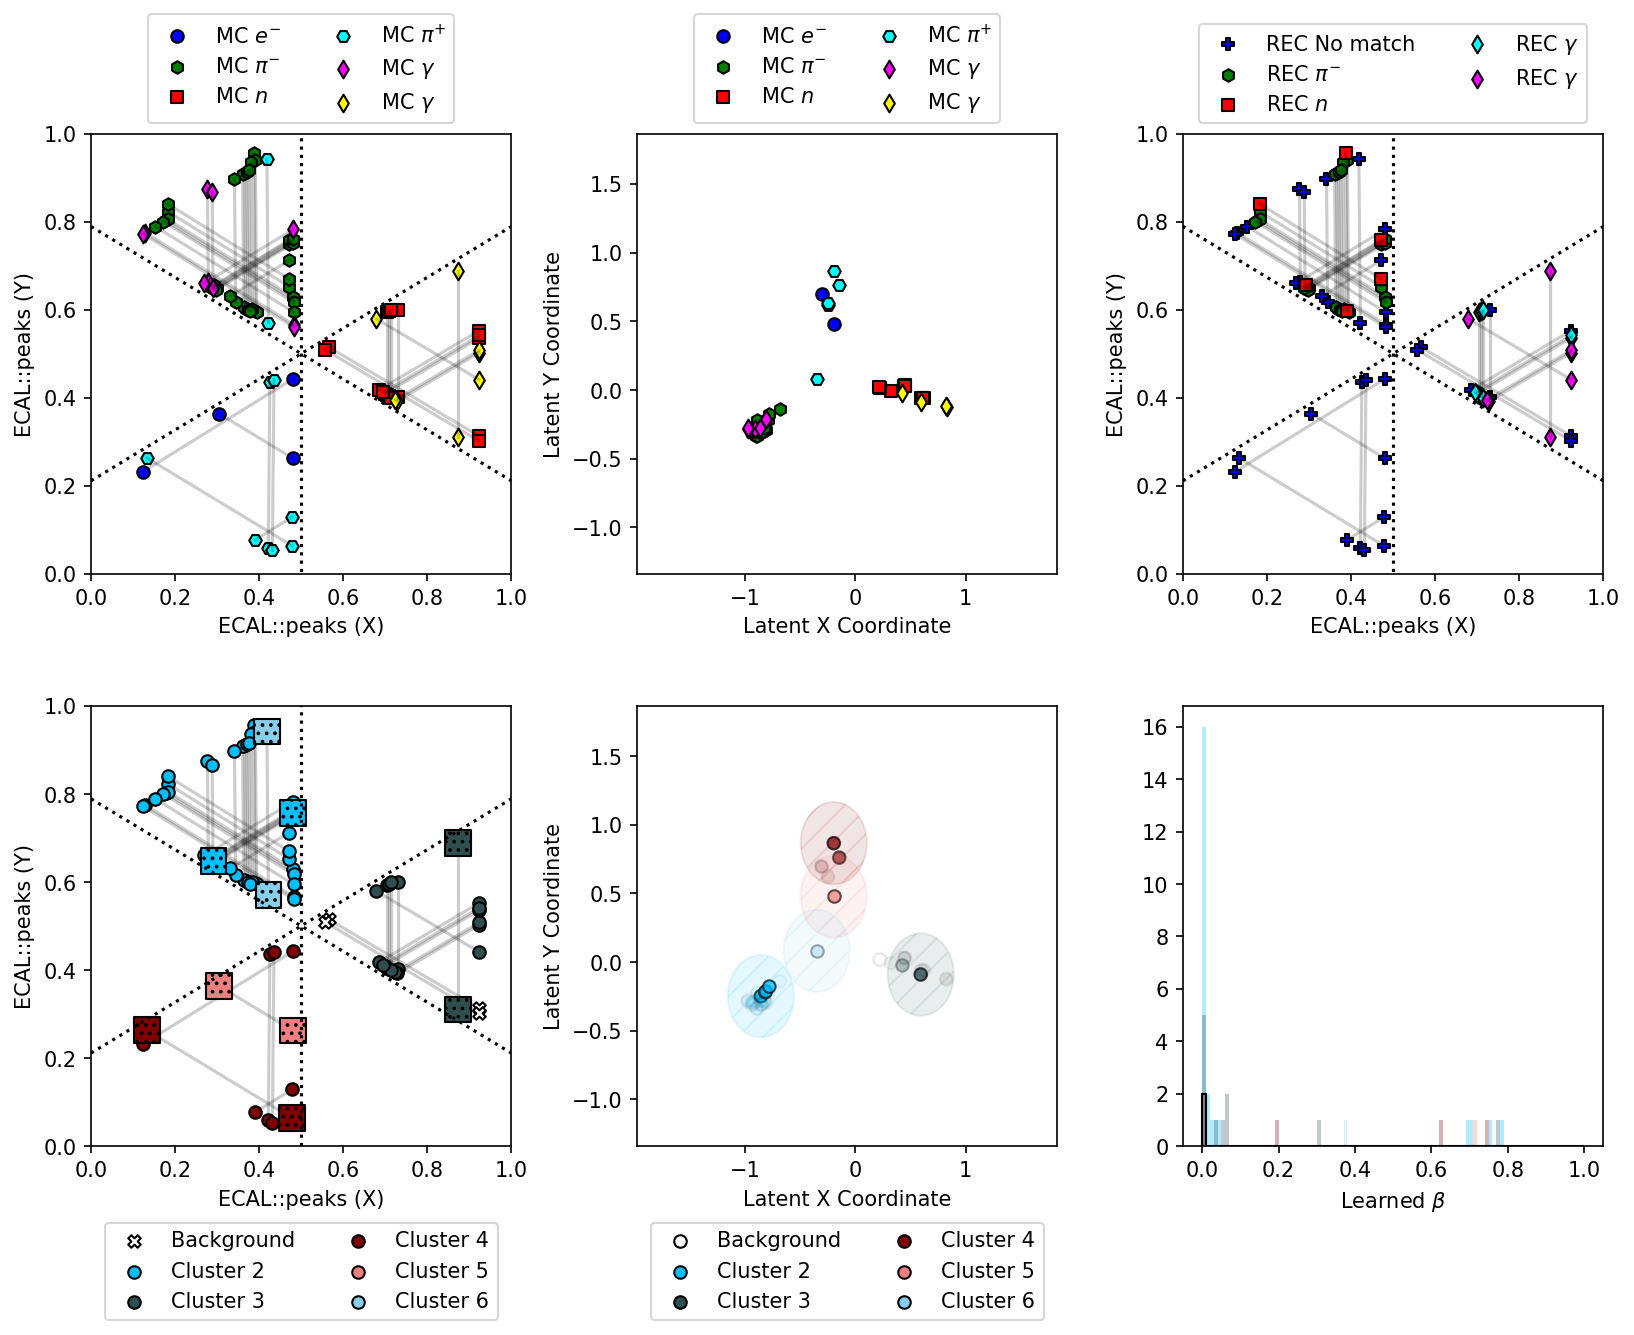

In [13]:
plotter = ModelEcalPlotter(evaluator.get_event_dataframe(83
                                                        ))
plotter.plot_all(tD=evaluator.tD)

In [36]:

loss_dict = {}
loc_dict  = {}

for e in range(200):

    # Extract the specific event data
    X_event = train_X[e:e+1]
    y_event = train_y[e:e+1]
    misc_event = train_misc[e:e+1]

    mask = y_event[:,:,0][0]==-1
    # Perform a forward pass to get the model's predictions
    y_pred_event = model.predict(X_event)
    xc = y_pred_event[:,:,1][0]
    yc = y_pred_event[:,:,2][0]
    xc = xc[~mask]
    yc = yc[~mask]
    # Calculate latent space coordinates of event
    loc_dict[f"ev_{e}"] = {"x": xc,
                           "y": yc,
                           "xc": np.mean(xc),
                           "yc": np.mean(yc),
                           "oxc": np.std(xc),
                           "oyc": np.std(yc)}
    
    # Calculate the loss using the custom loss function
    loss_fn = custom_loss(q_min=q_min)
    att_loss_fn = att_loss(q_min=q_min)
    rep_loss_fn = rep_loss(q_min=q_min)
    cow_loss_fn = cow_loss(q_min=q_min)
    nse_loss_fn = nse_loss(q_min=q_min)
    
    loss_dict[f"ev_{e}"] = {"att":att_loss_fn(y_event,y_pred_event).numpy(),
                                        "rep":rep_loss_fn(y_event,y_pred_event).numpy(),
                                        "cow":cow_loss_fn(y_event,y_pred_event).numpy(),
                                        "nse":nse_loss_fn(y_event,y_pred_event).numpy(),
                                        "tot":loss_fn(y_event,y_pred_event).numpy()}

1/1 [==============================] - 0s 26ms/step


NameError: name 'custom_loss' is not defined

In [44]:
df_loss = pd.DataFrame(loss_dict).transpose()
df_loss

,att,rep,cow,nse,tot
ev_0,3.866208,0.477764,0.041735,0.00001,4.385717
ev_1,0.052448,2.388508,0.051865,0.00001,2.492832
ev_2,1.692882,0.846335,0.056813,0.00001,2.596041
ev_3,0.126324,0.095056,0.788068,0.00001,1.009457
ev_4,0.000113,0.674227,0.057287,0.00001,0.731637
...,...,...,...,...,...
ev_195,0.084007,0.850012,0.031378,0.00001,0.965406
ev_196,1.382867,0.693222,0.068251,0.00001,2.144350
ev_197,0.997722,0.426306,0.050300,0.00001,1.474338
ev_198,0.047484,1.955180,0.032766,0.00001,2.035440


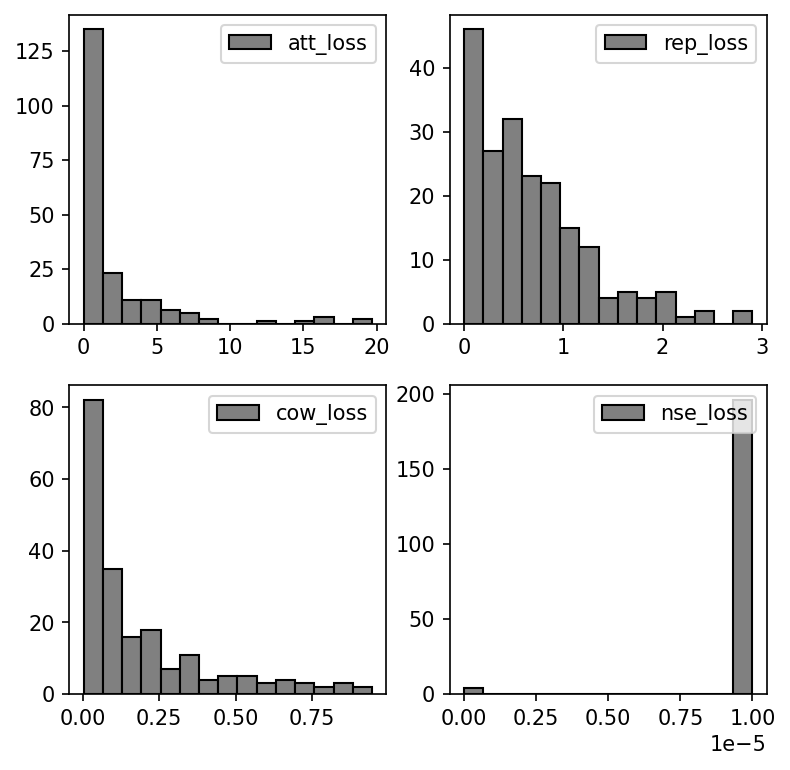

In [45]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,2,figsize=(6,6),dpi=150)
axs=axs.flatten()
for i,(key,values) in enumerate(df_loss.items()):
    axs[i].hist(values,bins=15,color="grey",edgecolor="k",label=f"{key}_loss")
    axs[i].legend(loc="upper right")
    if i == 3:
        break

In [47]:
fig,axs=plt.subplots(1,2,figsize=(6,4),dpi=150)
for i in range(len(loc_dict.keys())):
    try:
        x,y = loc_dict[f"ev_{i}"]["xc"], loc_dict[f"ev_{i}"]["yc"]
        ox,oy = loc_dict[f"ev_{i}"]["oxc"], loc_dict[f"ev_{i}"]["oyc"]
        zero_count = tf.reduce_sum(tf.cast(tf.equal(train_X[i][:,0], 0), tf.int32))
        if ox<0.1 and oy<0.1:
            print(i,zero_count)
        if ox>1 and oy>1:
            print("\t",i,zero_count)
        axs[0].errorbar([x],[y],xerr=[ox],yerr=[oy],capsize=2)

        x,y = loc_dict[f"ev_{i}"]["x"], loc_dict[f"ev_{i}"]["y"]
        axs[1].scatter(x,y,marker="o",edgecolor="k")
        if i>200:
            break
    except:
        continue
plt.close()

4 tf.Tensor(87, shape=(), dtype=int32)
9 tf.Tensor(99, shape=(), dtype=int32)
	 12 tf.Tensor(27, shape=(), dtype=int32)
	 15 tf.Tensor(0, shape=(), dtype=int32)
	 16 tf.Tensor(17, shape=(), dtype=int32)
18 tf.Tensor(78, shape=(), dtype=int32)
23 tf.Tensor(95, shape=(), dtype=int32)
	 24 tf.Tensor(22, shape=(), dtype=int32)
	 25 tf.Tensor(32, shape=(), dtype=int32)
	 35 tf.Tensor(11, shape=(), dtype=int32)
	 36 tf.Tensor(15, shape=(), dtype=int32)
44 tf.Tensor(78, shape=(), dtype=int32)
46 tf.Tensor(75, shape=(), dtype=int32)
48 tf.Tensor(64, shape=(), dtype=int32)
49 tf.Tensor(93, shape=(), dtype=int32)
56 tf.Tensor(83, shape=(), dtype=int32)
57 tf.Tensor(45, shape=(), dtype=int32)
	 59 tf.Tensor(17, shape=(), dtype=int32)
63 tf.Tensor(87, shape=(), dtype=int32)
65 tf.Tensor(84, shape=(), dtype=int32)
	 73 tf.Tensor(50, shape=(), dtype=int32)
74 tf.Tensor(90, shape=(), dtype=int32)
	 75 tf.Tensor(29, shape=(), dtype=int32)
83 tf.Tensor(91, shape=(), dtype=int32)
85 tf.Tensor(76, shape=

In [33]:
train_X[0][:,0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.05428043, 0.05026212, 0.04250493, 0.02643169, 0.02263958,
       0.01734392, 0.01726409, 0.0166853 , 0.0136516 , 0.01303289,
       0.01248736, 0.01213476, 0.01013891, 0.00840252, 0.00496966,
       0.00453058, 0.00413141, 0.00195593, 0.001284  , 0.00113763,
       0.00056549, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
for i, (key,values) in enumerate(loc_dict.items()):
    if loc_dict[f"ev_{i}"]["oyc"]<1 and loc_dict[f"ev_{i}"]["oxc"]<1:
        print(i)

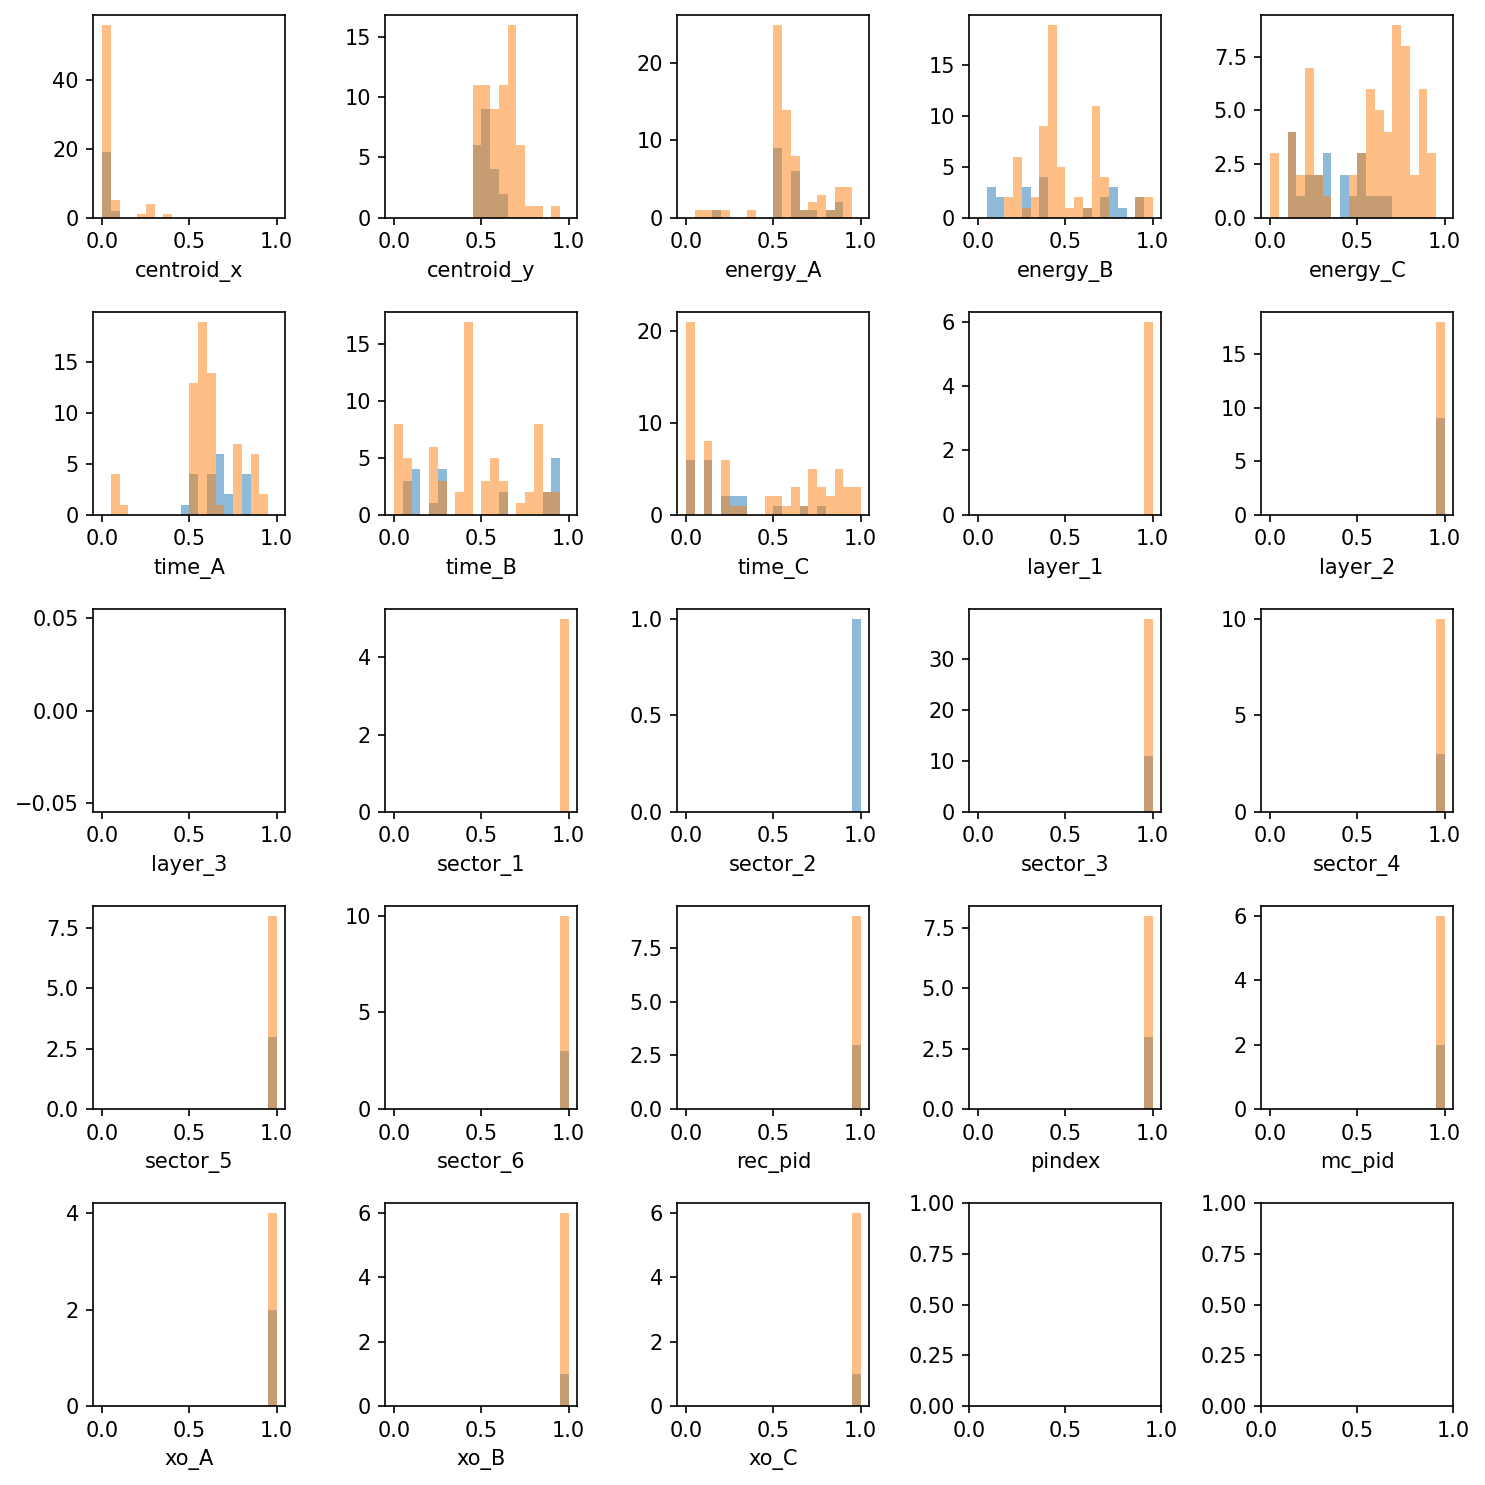

In [13]:
import matplotlib.pyplot as plt
Nplots = train_X.shape[2]
feature_columns = [
    'centroid_x', 'centroid_y',
    'energy_A', 'energy_B', 'energy_C',
    'time_A',   'time_B'  , 'time_C'  ,
    'layer_1', 'layer_2', 'layer_3',
    'sector_1', 'sector_2', 'sector_3',
     'sector_4', 'sector_5', 'sector_6', 
    'rec_pid', 'pindex', 'mc_pid',
    'xo_A','xo_B','xo_C','xe_A','xe_B','xe_C',
    'yo_A','yo_B','yo_C','ye_A','ye_B','ye_C', 'unique_otid',
]
rows = int(np.ceil(Nplots/5))
cols = 5
fig,axs=plt.subplots(rows,cols,figsize=(cols*2,rows*2),dpi=150)
axs=axs.flatten()
for i in range(Nplots):
    axs[i].hist(train_X[0,:,i],range=(0.00001,1),bins=20,alpha=0.5)
    axs[i].hist(train_X[2,:,i],range=(0.00001,1),bins=20,alpha=0.5)
    axs[i].set_xlabel(feature_columns[i])
plt.tight_layout()
plt.show()

In [33]:
train_X

<tf.Tensor: shape=(1552, 50, 2), dtype=float32, numpy=
array([[[0.4813114 , 0.46817783],
        [0.48638475, 0.46524873],
        [0.48471287, 0.46821114],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.5773115 , 0.66034335],
        [0.57391006, 0.66031003],
        [0.57898337, 0.65738094],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.15090397, 0.8147289 ],
        [0.1546432 , 0.8213472 ],
        [0.14333683, 0.8147995 ],
        ...,
        [0.34196052, 0.6426565 ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       ...,

       [[0.6959483 , 0.8131048 ],
        [0.7043654 , 0.8042509 ],
        [0.7010216 , 0.8101757 ],
        ...,
        [0.68645376, 0.827987  ],
        [0.70855933, 0.8409667 ],
        [0.71215594, 0.8346008 ]],

       [[0.6002198 , 0.6664993 ],
        [0.5926186 , 0